In [1]:
##combine PP and IO for NMF

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab

In [2]:
subj = 'EL011'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos

path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
# EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]




In [3]:
file_con = path_patient_analysis + '\\InputOutput\\'+cond_folder+'/data/con_trial_all.csv'
con_trial_IO = pd.read_csv(file_con)
con_trial_IO.insert(4, 'Intp',0)
con_trial_IO.insert(4, 'IPI',0)

In [4]:
file_con = path_patient_analysis + '\\PairedPulse\\'+cond_folder+'/data/con_trial_all.csv'
con_trial_PP = pd.read_csv(file_con)
con_trial_PP.insert(4, 'Intp', con_trial_PP.Int)
con_trial_PP.loc[(con_trial_PP.Int==0), 'Int'] = 2
con_trial_PP.Int = 2

In [5]:
con_trial_PP = con_trial_PP[con_trial_PP.Intp>0]
con_trial_PP = con_trial_PP.reset_index(drop=True)

In [6]:
con_trial_PP.Num = con_trial_PP.Num+np.max(con_trial_IO.Num+1)

NameError: name 'con_trial_exc' is not defined

In [8]:
con_trial_exc = pd.concat([con_trial_IO,con_trial_PP])
con_trial_exc = con_trial_exc.reset_index(drop=True)
con_trial_exc = con_trial_exc.drop(columns=['P2P', 'nLL', 'Condition', 'LL_SP'])
con_trial_exc= con_trial_exc.reset_index(drop=True)

In [9]:
con_trial_exc.loc[(con_trial_exc.SleepState == 'W'), 'SleepState'] = 'Wake'
con_trial_exc.loc[(con_trial_exc.Sleep == 0), 'SleepState'] = 'Wake'
con_trial_exc.loc[(con_trial_exc.Sleep > 1) & (con_trial_exc.Sleep < 4), 'SleepState'] = 'NREM'
con_trial_exc.loc[(con_trial_exc.Sleep == 1), 'SleepState'] = 'NREM1'
con_trial_exc.loc[(con_trial_exc.Sleep == 6), 'SleepState'] = 'SZ'
con_trial_exc.loc[(con_trial_exc.Sleep == 4), 'SleepState'] = 'REM'

In [46]:
con_trial_exc

,Chan,Stim,LL,IPI,Intp,Artefact,SleepState,Int,Hour,Block,Sleep,Num,Num_block,Date,d
0,0.0,65.0,1.196758,0.0,0.0,0.0,Wake,6.0,15.0,1.0,0.0,0.0,0.0,20220215.0,69.01
1,0.0,7.0,6.090275,0.0,0.0,0.0,Wake,5.0,15.0,1.0,0.0,1.0,1.0,20220215.0,11.46
2,0.0,27.0,1.624167,0.0,0.0,0.0,Wake,0.6,15.0,1.0,0.0,2.0,2.0,20220215.0,23.61
3,0.0,27.0,1.900588,0.0,0.0,0.0,Wake,8.0,15.0,1.0,0.0,3.0,3.0,20220215.0,23.61
4,0.0,7.0,5.776074,0.0,0.0,0.0,Wake,4.0,15.0,1.0,0.0,4.0,4.0,20220215.0,11.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648468,86.0,27.0,2.578655,1000.0,1.0,0.0,Wake,2.0,14.0,69.0,0.0,30438.0,271.0,20220218.0,66.56
2648469,86.0,27.0,2.516563,12.7,4.0,0.0,Wake,2.0,14.0,69.0,0.0,30439.0,272.0,20220218.0,66.56
2648470,86.0,7.0,2.925693,1600.0,2.0,0.0,Wake,2.0,14.0,69.0,0.0,30440.0,273.0,20220218.0,77.60
2648471,86.0,27.0,2.665101,25.5,2.0,0.0,Wake,2.0,14.0,69.0,0.0,30441.0,274.0,20220218.0,66.56


In [10]:
con_trial_exc

,Chan,Stim,LL,IPI,Intp,Artefact,SleepState,Int,Hour,Block,Sleep,Num,Num_block,Date,d
0,0.0,65.0,1.196758,0.0,0.0,0.0,Wake,6.0,15.0,1.0,0.0,0.0,0.0,20220215.0,69.01
1,0.0,7.0,6.090275,0.0,0.0,0.0,Wake,5.0,15.0,1.0,0.0,1.0,1.0,20220215.0,11.46
2,0.0,27.0,1.624167,0.0,0.0,0.0,Wake,0.6,15.0,1.0,0.0,2.0,2.0,20220215.0,23.61
3,0.0,27.0,1.900588,0.0,0.0,0.0,Wake,8.0,15.0,1.0,0.0,3.0,3.0,20220215.0,23.61
4,0.0,7.0,5.776074,0.0,0.0,0.0,Wake,4.0,15.0,1.0,0.0,4.0,4.0,20220215.0,11.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648468,86.0,27.0,2.578655,1000.0,1.0,0.0,Wake,2.0,14.0,69.0,0.0,30438.0,271.0,20220218.0,66.56
2648469,86.0,27.0,2.516563,12.7,4.0,0.0,Wake,2.0,14.0,69.0,0.0,30439.0,272.0,20220218.0,66.56
2648470,86.0,7.0,2.925693,1600.0,2.0,0.0,Wake,2.0,14.0,69.0,0.0,30440.0,273.0,20220218.0,77.60
2648471,86.0,27.0,2.665101,25.5,2.0,0.0,Wake,2.0,14.0,69.0,0.0,30441.0,274.0,20220218.0,66.56


In [18]:
import staNMF as st
from staNMF.nmf_models import spams_nmf
from sklearn.decomposition import NMF
from scipy.stats import entropy
import numpy as np

ModuleNotFoundError: No module named 'spams'

In [11]:
# This function will compute the entropy for each row of the input matrix
def get_entropy(L):
    E = np.array([entropy(row) for row in L])
    A = entropy(E)
    B = np.mean(E)
    return E, A, B

def recursive_stanmf(X, k_range, max_clusters, clusters=None, idx=None, parent_entropy=None, cluster_label='', threshold=0.1, level=0):
    if idx is None:
        idx = np.arange(X.shape[0])
    
    if clusters is None:
        clusters = []

    # Stop if the number of data points is less than the smallest possible number of clusters or if maximum number of clusters has been reached
    if X.shape[0] < min(k_range) or len(clusters) >= max_clusters:
        clusters.append((cluster_label, X, idx))
        return clusters

    # Apply stability NMF and compute instability
    folderID = "your_folder_" 
    model = st.staNMF(X, folderID=folderID, K1=min(k_range), K2=max(k_range), replicates=20, seed=123)
    model.NMF_finished = True
    model.runNMF(spams_nmf(bootstrap=False))
    model.instability("spams_nmf")
    best_k = k_range[np.argmin(model.get_instability())]

    # Run NMF with best k
    model = NMF(n_components=best_k, init='random', random_state=0)
    W = model.fit_transform(X)

    best_f_values = []
    new_clusters = []  # New list to keep track of the new clusters
    for i in range(best_k):
        component_idx = np.argmax(W, axis=1) == i
        best_clusters = X[component_idx]
        new_label = cluster_label + 'X' + str(level+1) + str(i+1)  # Append the child label to the parent label

        _, A_cluster, B_cluster = get_entropy(best_clusters)
        f_value = A_cluster - B_cluster

        if parent_entropy is None or f_value < parent_entropy:
            best_f_values.append(f_value)
            new_clusters.append((new_label, best_clusters, idx[component_idx]))

    # Only go to next level of recursion if the conditions based on f and g values are met
    for new_cluster in new_clusters:
        new_label, best_clusters, new_idx = new_cluster

        clusters = recursive_stanmf(best_clusters, k_range, max_clusters, clusters, new_idx, f_value, new_label, threshold, level+1)
        
        if len(best_f_values) == 0:  # New condition to handle empty sub_f_values
            clusters.append(new_cluster)
        else:
            g_value = sum(abs(np.array(best_f_values) - np.array(best_f_values)))
            if g_value > threshold:
                clusters.append(new_cluster)
                
    return clusters


from sklearn import datasets

## NMF

In [19]:
import numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

In [21]:
V

array([[1.19675829, 6.09027518, 1.62416676, ..., 4.85237123, 1.48762931,
        1.68516032],
       [1.73966084, 5.78473   , 1.75765887, ..., 4.33879286, 1.84162422,
        2.27078622],
       [1.81291845, 4.22066096, 2.08761522, ..., 3.59920762, 3.31737552,
        4.17392799],
       ...,
       [3.41352949, 2.58027441, 3.73234214, ..., 2.73849398, 3.08766724,
        2.91305826],
       [3.66368144, 2.63485019, 2.29987689, ..., 2.68212288, 3.50577452,
        2.8891297 ],
       [3.96028338, 2.2231101 , 3.57977056, ..., 2.92569342, 2.66510118,
        4.10188937]])

In [38]:
level_1_nmf = NMF(n_components=5)  # Assuming you want 4 clusters for stimulation sites
W_level_1 = level_1_nmf.fit_transform(V)  # Average intensity across all intensities
H_level_1 = level_1_nmf.components_


c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [41]:
# Second level: Further cluster based on intensity dynamics
level_2_clusters = []
for i in range(1,level_1_nmf.n_components):
    V_level_2 = V[W_level_1[:, i] > 0]  # Select individuals from the current level 1 cluster
    level_2_nmf = NMF(n_components=2)  # Assuming you want 2 clusters for intensity dynamics
    W_level_2 = level_2_nmf.fit_transform(V_level_2)
    H_level_2 = level_2_nmf.components_
    level_2_clusters.append((W_level_2, H_level_2))


c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renam

In [45]:
H_level_1.shape

(5, 30443)

In [ ]:
summ2 = con_trial_exc.groupby(['Num'], as_index=False)[col0].mean()

In [27]:
# Plot H coefficient against stimulation intensity for each cluster
for i, cluster in enumerate(level_2_clusters):
    W_level_2, H_level_2 = cluster
    num_individuals_level_2 = W_level_2.shape[0]
    plt.figure()
    for j in range(num_individuals_level_2):
        plt.plot(np.arange(num_intensities), H_level_2[j])

    plt.legend()
    plt.show()

NameError: name 'num_intensities' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
# Assuming you have your input matrix V with shape (num_individuals, num_stimulations * num_intensities)
# You can reshape it to have separate dimensions for stimulations and intensities
num_individuals = V.shape[0]
num_stimulations = 4
num_intensities = 10
V_reshaped = V.reshape(num_individuals, num_stimulations, num_intensities)
# Perform hierarchical NMF clustering
# First level: Cluster individuals based on reactive stimulation sites
level_1_nmf = NMF(n_components=4)  # Assuming you want 4 clusters for stimulation sites
W_level_1 = level_1_nmf.fit_transform(V_reshaped.mean(axis=2))  # Average intensity across all intensities
H_level_1 = level_1_nmf.components_
# Second level: Further cluster based on intensity dynamics
level_2_clusters = []
for i in range(level_1_nmf.n_components):
    V_level_2 = V_reshaped[W_level_1[:, i] > 0]  # Select individuals from the current level 1 cluster
    level_2_nmf = NMF(n_components=2)  # Assuming you want 2 clusters for intensity dynamics
    W_level_2 = level_2_nmf.fit_transform(V_level_2)
    H_level_2 = level_2_nmf.components_
    level_2_clusters.append((W_level_2, H_level_2))
# Plot H coefficient against stimulation intensity for each cluster
for i, cluster in enumerate(level_2_clusters):
    W_level_2, H_level_2 = cluster
    num_individuals_level_2 = W_level_2.shape[0]
    cluster_label = f”Cluster {i+1}”
    plt.figure()
    for j in range(num_individuals_level_2):
        plt.plot(np.arange(num_intensities), H_level_2[j], label=f”Individual {j+1}“)
    plt.xlabel(“Stimulation Intensity”)
    plt.ylabel(“H Coefficient”)
    plt.title(f”{cluster_label}: Dynamics of each individual”)
    plt.legend()
    plt.show()

In [ ]:
V = summ.unstack(level='Num').values

In [151]:
con_trial_exc0 = con_trial_exc[con_trial_exc.IPI==0]
con_trial_exc0 = con_trial_exc0.reset_index(drop=True)

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Shape of passed values is (4, 1), indices imply (4, 4)

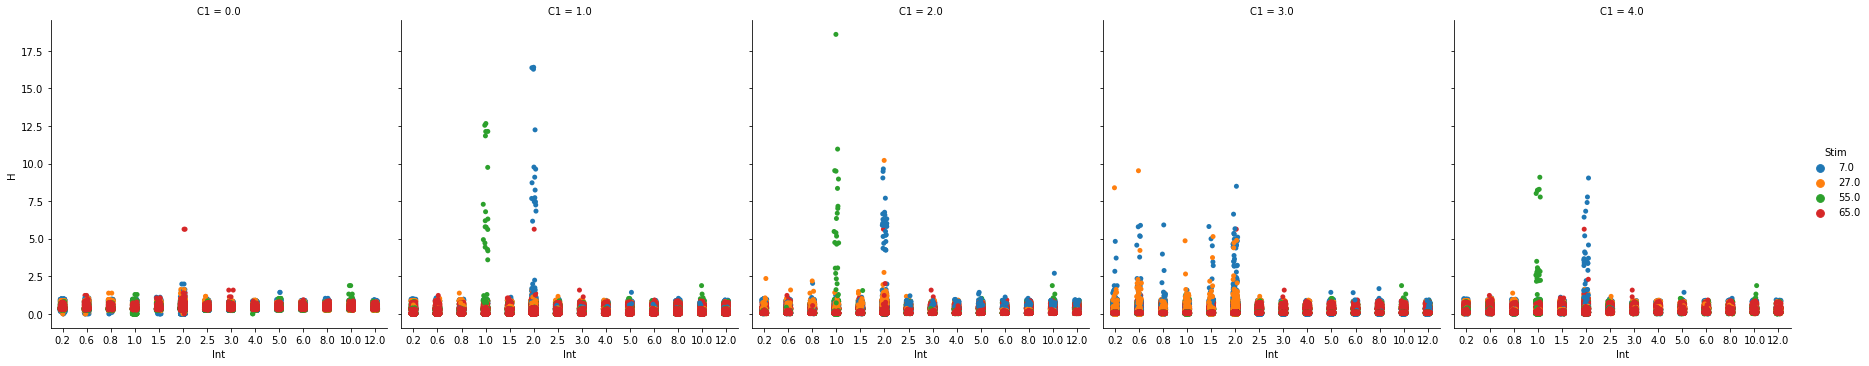

In [149]:
sns.catplot(x='Int', y= 'H', hue='Stim', col='C1', data = pd_cluster_all)

In [159]:
grouped

,Chan,Stim,Int,Num,LL
0,0.0,7.0,0.2,76.0,1.467085
1,0.0,7.0,0.2,123.0,2.567319
2,0.0,7.0,0.2,150.0,1.046553
3,0.0,7.0,0.2,222.0,1.086408
4,0.0,7.0,0.2,294.0,1.666516
...,...,...,...,...,...
1008344,86.0,65.0,12.0,11352.0,2.509105
1008345,86.0,65.0,12.0,11388.0,3.135301
1008346,86.0,65.0,12.0,11459.0,2.520047
1008347,86.0,65.0,12.0,11461.0,3.451372


In [166]:
con_trial_exc0

,Chan,Stim,LL,IPI,Intp,Artefact,SleepState,Int,Hour,Block,Sleep,Num,Num_block,Date,d
0,0.0,65.0,1.196758,0.0,0.0,0.0,Wake,6.0,15.0,1.0,0.0,0.0,0.0,20220215.0,69.01
1,0.0,7.0,6.090275,0.0,0.0,0.0,Wake,5.0,15.0,1.0,0.0,1.0,1.0,20220215.0,11.46
2,0.0,27.0,1.624167,0.0,0.0,0.0,Wake,0.6,15.0,1.0,0.0,2.0,2.0,20220215.0,23.61
3,0.0,27.0,1.900588,0.0,0.0,0.0,Wake,8.0,15.0,1.0,0.0,3.0,3.0,20220215.0,23.61
4,0.0,7.0,5.776074,0.0,0.0,0.0,Wake,4.0,15.0,1.0,0.0,4.0,4.0,20220215.0,11.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008344,86.0,27.0,4.033732,0.0,0.0,0.0,Wake,2.0,14.0,69.0,0.0,11585.0,162.0,20220218.0,66.56
1008345,86.0,65.0,4.677263,0.0,0.0,0.0,Wake,3.0,14.0,69.0,0.0,11586.0,163.0,20220218.0,67.19
1008346,86.0,55.0,2.615093,0.0,0.0,0.0,Wake,1.5,14.0,69.0,0.0,11587.0,164.0,20220218.0,65.24
1008347,86.0,27.0,4.266156,0.0,0.0,0.0,Wake,1.0,14.0,69.0,0.0,11588.0,165.0,20220218.0,66.56


In [168]:
grouped

,Chan,Stim,Int,Num,LL
0,0.0,7.0,0.2,76.0,1.467085
1,0.0,7.0,0.2,123.0,2.567319
2,0.0,7.0,0.2,150.0,1.046553
3,0.0,7.0,0.2,222.0,1.086408
4,0.0,7.0,0.2,294.0,1.666516
...,...,...,...,...,...
1008344,86.0,65.0,12.0,11352.0,2.509105
1008345,86.0,65.0,12.0,11388.0,3.135301
1008346,86.0,65.0,12.0,11459.0,2.520047
1008347,86.0,65.0,12.0,11461.0,3.451372


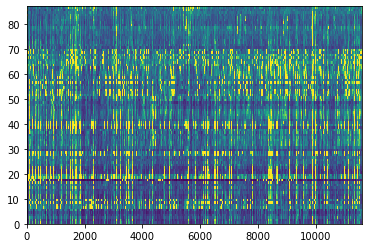

In [170]:
plt.pcolormesh(V, vmax = 7)

In [173]:
grouped0

,Stim,Int,Num,LL
0,7.0,0.2,76.0,3.342930
1,7.0,0.2,123.0,2.263827
2,7.0,0.2,150.0,2.648067
3,7.0,0.2,222.0,3.357545
4,7.0,0.2,294.0,2.969020
...,...,...,...,...
11586,65.0,12.0,11352.0,3.626245
11587,65.0,12.0,11388.0,3.355228
11588,65.0,12.0,11459.0,3.858922
11589,65.0,12.0,11461.0,3.385449


In [176]:
con_trial_exc0.groupby(['Num', 'Stim', 'Int'], as_index =False)['LL'].mean()

,Num,Stim,Int,LL
0,0.0,65.0,6.0,2.934282
1,1.0,7.0,5.0,5.957379
2,2.0,27.0,0.6,2.304374
3,3.0,27.0,8.0,3.051362
4,4.0,7.0,4.0,6.314526
...,...,...,...,...
11586,11586.0,65.0,3.0,2.624916
11587,11587.0,55.0,1.5,2.595986
11588,11588.0,27.0,1.0,2.244615
11589,11589.0,65.0,12.0,2.913268


In [172]:
con_trial_exc0

,Chan,Stim,LL,IPI,Intp,Artefact,SleepState,Int,Hour,Block,Sleep,Num,Num_block,Date,d
0,0.0,65.0,1.196758,0.0,0.0,0.0,Wake,6.0,15.0,1.0,0.0,0.0,0.0,20220215.0,69.01
1,0.0,7.0,6.090275,0.0,0.0,0.0,Wake,5.0,15.0,1.0,0.0,1.0,1.0,20220215.0,11.46
2,0.0,27.0,1.624167,0.0,0.0,0.0,Wake,0.6,15.0,1.0,0.0,2.0,2.0,20220215.0,23.61
3,0.0,27.0,1.900588,0.0,0.0,0.0,Wake,8.0,15.0,1.0,0.0,3.0,3.0,20220215.0,23.61
4,0.0,7.0,5.776074,0.0,0.0,0.0,Wake,4.0,15.0,1.0,0.0,4.0,4.0,20220215.0,11.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008344,86.0,27.0,4.033732,0.0,0.0,0.0,Wake,2.0,14.0,69.0,0.0,11585.0,162.0,20220218.0,66.56
1008345,86.0,65.0,4.677263,0.0,0.0,0.0,Wake,3.0,14.0,69.0,0.0,11586.0,163.0,20220218.0,67.19
1008346,86.0,55.0,2.615093,0.0,0.0,0.0,Wake,1.5,14.0,69.0,0.0,11587.0,164.0,20220218.0,65.24
1008347,86.0,27.0,4.266156,0.0,0.0,0.0,Wake,1.0,14.0,69.0,0.0,11588.0,165.0,20220218.0,66.56


In [181]:
# Assuming you have your input table as a pandas DataFrame
# Group the table by 'Chan', 'Stim', 'Num', and calculate the mean of 'LL'
grouped0 = con_trial_exc0.groupby(['Num', 'Stim', 'Int'])['LL'].mean().reset_index()
stimulation_sites = grouped0.Stim.values
intensities = grouped0.Int.values
numbers = grouped0.Num.values

grouped = con_trial_exc0.groupby(['Chan', 'Stim', 'Int', 'Num'])['LL'].mean().reset_index()
# Pivot the grouped table to get the input matrix V
V = grouped.pivot(index='Chan', columns='Num', values='LL').values
V[np.isnan(V)] = np.mean(np.nanmean(V,1))
V[np.isnan(V)] = 1

k = 7
# Perform hierarchical NMF clustering
# First level: Cluster individuals based on reactive stimulation sites
level_1_nmf = NMF(n_components=k)  # Assuming you want 4 clusters for stimulation sites
W_level_1 = level_1_nmf.fit_transform(V)  # Average across all intensities
H_level_1 = level_1_nmf.components_

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [182]:
start = 1
for i in range(k):
    pd_cluster = pd.DataFrame(np.array([stimulation_sites, intensities, H_level_1[i], i+np.zeros((len(intensities),))]).T, columns=['Stim', 'Int', 'H', 'C1'])
    if start:
        pd_cluster_all = pd_cluster
        start = 0
    else:
        pd_cluster_all = pd.concat([pd_cluster_all,pd_cluster ])

(0.0, 3.0)

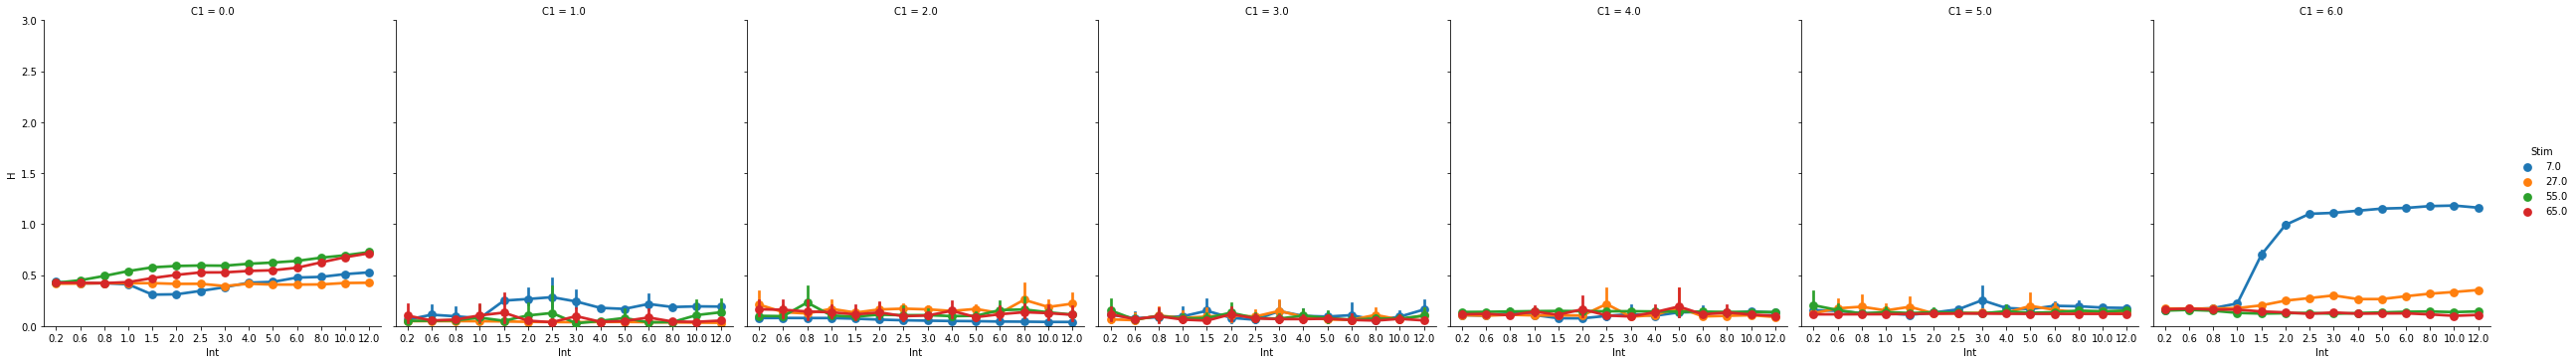

In [185]:
sns.catplot(x='Int', y= 'H', hue='Stim', col='C1', data = pd_cluster_all, kind='point')
plt.ylim([0,3])

In [82]:
# Assuming you have your input table as a pandas DataFrame
# Group the table by 'Chan', 'Stim', 'Num', and calculate the mean of 'LL'
grouped = con_trial_exc.groupby(['Chan', 'Stim', 'Int', 'Num'])['LL'].mean().reset_index()
stimulation_sites = grouped.Stim.values
# Pivot the grouped table to get the input matrix V
V = grouped.pivot(index='Chan', columns='Num', values='LL').values
V[np.isnan(V)] = np.mean(np.nanmean(V,1))
V[np.isnan(V)] = 1

# Perform hierarchical NMF clustering
# First level: Cluster individuals based on reactive stimulation sites
level_1_nmf = NMF(n_components=5)  # Assuming you want 4 clusters for stimulation sites
W_level_1 = level_1_nmf.fit_transform(V)  # Average across all intensities
H_level_1 = level_1_nmf.components_

# Second level: Further cluster based on intensity dynamics
level_2_clusters = []
for i in range(level_1_nmf.n_components):
    individuals_level_1 = np.where(W_level_1[:, i] > 0.5)[0]  # Select individuals from the current level 1 cluster
    V_level_2 = V[individuals_level_1]
    level_2_nmf = NMF(n_components=2)  # Assuming you want 2 clusters for intensity dynamics
    W_level_2 = level_2_nmf.fit_transform(V_level_2)
    H_level_2 = level_2_nmf.components_
    level_2_clusters.append((W_level_2, H_level_2, individuals_level_1))

# Plot H coefficient against stimulation intensity for each cluster, color-coded by stimulation site
for i, cluster in enumerate(level_2_clusters):
    W_level_2, H_level_2, individuals_level_1 = cluster
    cluster_label = f"Cluster {i+1}"

    plt.figure()
    for j, clusterl_idx in enumerate(range(H_level_2.shape[0])):
        stimulation_sites = grouped.loc[grouped['Chan'] == individual_idx, 'Stim']
        for site in np.unique(stimulation_sites):
            stim_index = grouped.loc[(grouped['Stim'] == site), 'Num'].values.astype('int')
            activation = H_level_2[j,stim_index]
            intensities = grouped.loc[(grouped['Stim'] == site), 'Int'].values
            plt.scatter(intensities, activation, label=f"Individual {individual_idx+1}, Site {site}")

    plt.xlabel("Stimulation Intensity")
    plt.ylabel("H Coefficient")
    plt.title(f"{cluster_label}: Dynamics of each individual")
    plt.legend()
    plt.show()

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renam

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000120356F7C18> (for post_execute):


KeyboardInterrupt: 

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x00000120356F55E8> (for post_execute):


KeyboardInterrupt: 

In [90]:
grouped

,Chan,Stim,Int,Num,LL
0,0.0,7.0,0.2,76.0,1.467085
1,0.0,7.0,0.2,123.0,2.567319
2,0.0,7.0,0.2,150.0,1.046553
3,0.0,7.0,0.2,222.0,1.086408
4,0.0,7.0,0.2,294.0,1.666516
...,...,...,...,...,...
2648468,86.0,65.0,12.0,11352.0,2.509105
2648469,86.0,65.0,12.0,11388.0,3.135301
2648470,86.0,65.0,12.0,11459.0,2.520047
2648471,86.0,65.0,12.0,11461.0,3.451372


In [89]:
intensities.shape

(662664,)

In [88]:
activation.shape

(662664,)

In [85]:
grouped

,Chan,Stim,Int,Num,LL
0,0.0,7.0,0.2,76.0,1.467085
1,0.0,7.0,0.2,123.0,2.567319
2,0.0,7.0,0.2,150.0,1.046553
3,0.0,7.0,0.2,222.0,1.086408
4,0.0,7.0,0.2,294.0,1.666516
...,...,...,...,...,...
2648468,86.0,65.0,12.0,11352.0,2.509105
2648469,86.0,65.0,12.0,11388.0,3.135301
2648470,86.0,65.0,12.0,11459.0,2.520047
2648471,86.0,65.0,12.0,11461.0,3.451372


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-84-ec8996adc737>", line 11, in <module>
    plt.scatter(intensities, activation, label=f"Individual {individual_idx+1}, Site {site}")
  File "C:\Users\i0328442\AppData\Roaming\Python\Python37\site-packages\matplotlib\pyplot.py", line 2821, in scatter
    **({"data": data} if data is not None else {}), **kwargs)
  File "C:\Users\i0328442\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py", line 1414, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "C:\Users\i0328442\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_axes.py", line 4455, in scatter
    offsets = np.ma.column_stack([x, y])
  File "C:\Users\i0328442\AppData\Roaming\Python\Python37\site-packages\numpy\ma\extras.py", l

TypeError: object of type 'NoneType' has no len()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000120356F7C18> (for post_execute):


KeyboardInterrupt: 

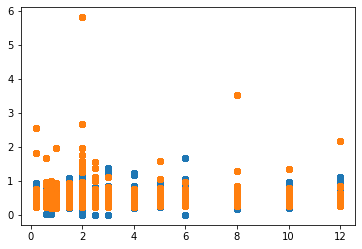

In [84]:
W_level_2, H_level_2, individuals_level_1 = cluster
cluster_label = f"Cluster {i+1}"

plt.figure()
for j, clusterl_idx in enumerate(range(H_level_2.shape[0])):
    stimulation_sites = grouped.loc[grouped['Chan'] == individual_idx, 'Stim']
    for site in np.unique(stimulation_sites):
        stim_index = grouped.loc[(grouped['Stim'] == site), 'Num'].values.astype('int')
        activation = H_level_2[j,stim_index]
        intensities = grouped.loc[(grouped['Stim'] == site), 'Int'].values
        plt.scatter(intensities, activation, label=f"Individual {individual_idx+1}, Site {site}")

plt.xlabel("Stimulation Intensity")
plt.ylabel("H Coefficient")
plt.title(f"{cluster_label}: Dynamics of each individual")
plt.legend()
plt.show()

In [77]:
H_level_2.shape

(2, 30443)

In [15]:
clusters = recursive_stanmf(V, range(2, 5), max_clusters=10)

NameError: name 'st' is not defined

In [12]:
np.unique(con_trial_exc.Stim)

array([ 7., 27., 55., 65.])

In [13]:
nums_id = np.unique(con_trial_exc.Num).astype('int')

In [ ]:
def run_hier_nmf(X)

In [ ]:
digits = datasets.load_digits()
X = digits.data
y_true = digits.target

clusters = recursive_stanmf(X, range(2, 5), max_clusters=10)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = np.zeros(X.shape[0])
for i, (_, _, cluster_idx) in enumerate(clusters):
    y_pred[cluster_idx] = i

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', square=True, cmap='Blues')
plt.xlabel('Predicted cluster')
plt.ylabel('True class')
plt.title('Confusion Matrix')
plt.show()


In [94]:
con_trial_exc_Stim = con_trial_exc[con_trial_exc.Stim==7]
con_trial_exc_Stim= con_trial_exc_Stim.reset_index(drop=True)

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


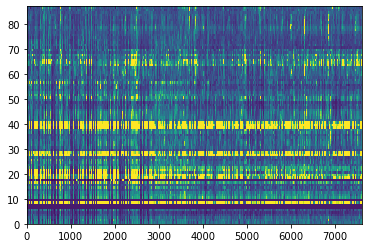

In [14]:
import NMF_funcs as NMFf

In [15]:
[W, W0, H] = NMFf.get_nnmf_Epi(V,3, it=4000)

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [25]:
from sklearn.cluster import KMeans

In [126]:
np.percentile(Vz,90)

1.1620952417962676

In [133]:
np.mean(Vz,1)

array([-2.01381199e-01, -2.24205157e-01, -2.89872730e-01, -5.96614960e-01,
       -7.99701324e-01, -4.43913238e-01, -1.20889679e+00, -1.20889679e+00,
        1.80708179e+00, -1.20889679e+00,  3.21987336e-01,  1.21716312e-01,
        4.73291831e-02, -3.89657780e-01, -6.07593187e-02, -4.37270371e-01,
        6.06371082e-01, -9.86874494e-01,  1.30625675e+00,  1.73780949e+00,
        3.13086456e-01,  7.08958142e-01,  3.71989886e-01, -6.82859044e-02,
       -8.07641834e-02, -1.38777328e-01, -3.33973567e-01,  2.89140887e+00,
        1.30640013e+00, -5.51753807e-01, -2.49520635e-01, -9.57330724e-02,
       -1.18554130e-01, -1.43142282e-01, -2.03187664e-01, -3.40151743e-01,
        3.28965683e-02,  9.46666173e-02,  2.17356031e+00,  2.77267639e+00,
        1.29617301e+00, -1.83266122e-01,  1.39100366e-04,  2.58578172e-02,
        2.30172742e-02, -1.19116847e-01, -4.23736358e-01, -4.54275328e-01,
       -5.91690168e-01, -3.30804699e-02,  1.91161862e-01,  4.52241797e-02,
       -1.46547359e-01, -

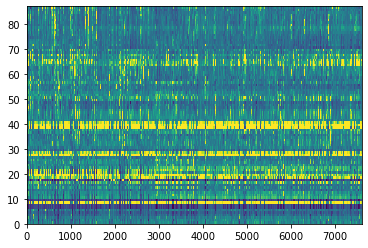

In [136]:
Vz = scipy.stats.zscore(V, axis=0)
Vz[np.isnan(Vz)] = np.mean(np.nanmean(Vz,1))
Vz[np.isnan(Vz)] = 1
plt.pcolormesh(Vz,vmin = -2,  vmax = 2)

In [141]:
kmeans = KMeans(n_clusters=3).fit(Vz)
kmeans.labels_

#kmeans.predict(X)
H = kmeans.cluster_centers_
y = kmeans.predict(Vz)
y

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 2, 0, 2, 0, 2, 1, 1, 0, 0,
       0, 0, 0, 0, 2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 1, 2, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [142]:
col0 = ['Stim', 'Int', 'Intp','IPI','Block', 'Hour', 'Date', 'Sleep']  #  'Hour',
col = ['Stim', 'Int', 'Intp','IPI','Block', 'Hour', 'Date', 'Sleep']  #  'Hour',
W_col = []
H_col = []
for i in range(H.shape[0]):
    col.append('H' + str(i + 1))
    W_col.append('W' + str(i + 1))
    H_col.append('H' + str(i + 1))

con_nmf = np.zeros((H.shape[1], len(col0) + H.shape[0]))
con_nmf[:, len(col0):] = H.T
# add stim channel, Hour and Intensity
summ2 = con_trial_exc_Stim.groupby(['Num'], as_index=False)[col0].mean()
con_nmf[:, 0:len(col0)] = summ2.values[:, 1:]
con_nmf = pd.DataFrame(con_nmf, columns=col)
int_all = np.unique(con_nmf.Int)
ipi_all = np.unique(con_nmf.IPI)

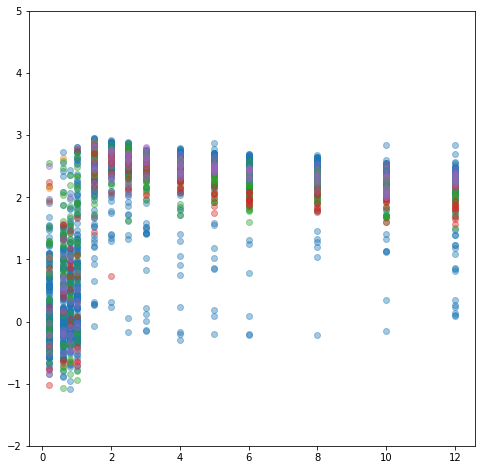

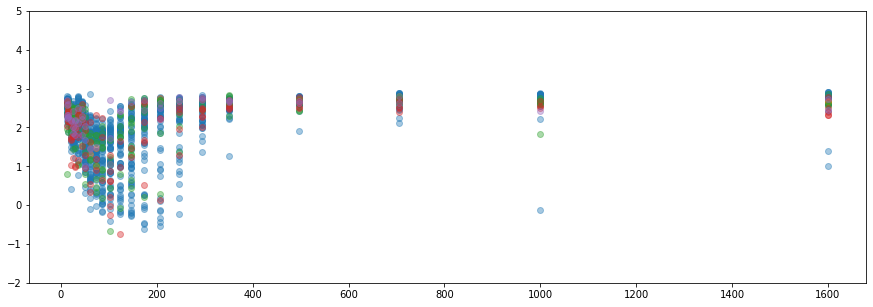

In [152]:
h  ='H2'
plt.figure(figsize=(8,8))
for s in np.unique(con_nmf.Sleep):
    data_plot = con_nmf[(con_nmf.Sleep==s)&(con_nmf.IPI==0)]
    plt.scatter(data_plot.Int, data_plot[h], alpha= 0.4)
plt.ylim([-2,5])
plt.show()
plt.figure(figsize=(15,5))
for s in np.unique(con_nmf.Sleep):
    data_plot = con_nmf[(con_nmf.Sleep==s)&(con_nmf.Intp==2)]
    plt.scatter(data_plot.IPI, data_plot[h], alpha= 0.4)
#sns.stripplot(x='IPI', y= h, hue='Sleep', data=con_nmf[(con_nmf.Intp==2)])
plt.ylim([-2,5])
#plt.xscale('log')
plt.show()